# Load all Lib

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import os

import torch.nn as nn
import torch.optim as optim
import torch
import torch.nn.functional as functional

In [2]:
# intrinsic matrix of the camera
IntrinsicMatrix = np.array([[1.3533e3, 0, 1.1605e3], 
                            [0, 1.418e3, 529.8685], 
                            [0, 0, 1]])

# camera height
H = 7.0  
# 4.5 m for the lower one. 

# angle of camera when it is stable
incStab = 73 * np.pi / 180
rollStab = 0 * np.pi / 180
aziStab = 0  

# Load the model

In [3]:
import torch.nn as nn
import torch.optim as optim
import torch
import torch.nn.functional as functional

class double_conv(nn.Module):
    """(conv => BN => ReLU) * 2"""

    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(nn.MaxPool2d(2), double_conv(in_ch, out_ch))

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = functional.pad(x1, (diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2))
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256, False)
        self.up2 = up(512, 128, False)
        self.up3 = up(256, 64, False)
        self.up4 = up(128, 64, False)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return torch.sigmoid(x)
    
    
unet_model = UNet(n_channels=1, n_classes=1).float()
unet_model.load_state_dict(torch.load("../model_cifar_200.pt"))

<All keys matched successfully>

# Preprocessing

## Horizon Detection

In [4]:
import numpy as np
import cv2

def Image2World(u,v,H,roll,pitch,yaw,IntrinsicMatrix):
    """_summary_

    Args:
        u (int): location at the x axis in image coordinate
        v (int): location at the y axis in image coordinate
        H (float): camera height above mean water level
        roll (float): change of the angle of camera around the y axis
        pitch (float): change of the angle of camera around the x axis
        yaw (float): change of the angle of cameraaround the z axis
        IntrinsicMatrix (ndarray): intrinsic matrix of the camera

    The definition is according to the paper:
    Schwendeman, M., & Thomson, J. (2015). 
    A horizon-tracking method for shipboard video stabilization and rectification.
    Journal of Atmospheric and Oceanic Technology, 32(1), 164-176.
    Returns:
        x (float): corresponding x location in real-world coordinate. Unit is m.
        y (float): corresponding y location in real-world coordinate. Unit is m.
        
    """
    R_roll = np.array([[np.cos(roll), -np.sin(roll), 0],
                       [np.sin(roll), np.cos(roll), 0], 
                       [0, 0, 1]])
    R_pitch = np.array([[1, 0, 0], 
                        [0, -np.cos(pitch), -np.sin(pitch)], 
                        [0, np.sin(pitch), -np.cos(pitch)]])
    R_yaw = np.array([[np.cos(yaw), 0, -np.sin(yaw)],
                      [0, 1, 0], 
                      [np.sin(yaw), 0, np.cos(yaw)]])

    R = R_yaw.dot(R_roll.dot(R_pitch))
    # 矩阵求逆
    UV0 = np.array([u, v])
    one = np.ones(u.shape[0])
    UV1 = np.r_[UV0, np.array([one])]
    UV = np.r_[UV1, np.array([one])]

    zero = np.zeros(R.shape[0])
    r = np.c_[R, zero.T]
    rr = np.r_[r, np.array([np.append(zero, 1)])]

    K = np.c_[IntrinsicMatrix, zero.T]
    KK = np.r_[K, np.array([np.append(zero, 1)])]

    a = np.linalg.inv(KK.dot(rr)).dot(UV)

    x = -np.divide(a[0, :], a[2, :]) * H
    y = -np.divide(a[1, :], a[2, :]) * H

    return (x, y)

def Image2Image(u1,v1,roll1,pitch1,yaw1,roll2,pitch2,yaw2,IntrinsicMatrix):
    """_summary_

    Args:
        u1 (_type_): _description_
        v1 (_type_): _description_
        roll1 (_type_): _description_
        pitch1 (_type_): _description_
        yaw1 (_type_): _description_
        roll2 (_type_): _description_
        pitch2 (_type_): _description_
        yaw2 (_type_): _description_
        IntrinsicMatrix (_type_): _description_

    Returns:
        _type_: _description_
    """
    R_roll1 = np.array([[np.cos(roll1), -np.sin(roll1), 0],
                        [np.sin(roll1), np.cos(roll1), 0], 
                        [0, 0, 1]])
    R_pitch1 = np.array([[1, 0, 0], 
                         [0, -np.cos(pitch1), -np.sin(pitch1)], 
                         [0, np.sin(pitch1), -np.cos(pitch1)]])
    R_yaw1 = np.array([[np.cos(yaw1), 0, -np.sin(yaw1)],
                       [0, 1, 0], 
                       [np.sin(yaw1), 0, np.cos(yaw1)]])
    R1 = R_yaw1.dot(R_roll1.dot(R_pitch1))

    R_roll2 = np.array([[np.cos(roll2), -np.sin(roll2), 0],
                        [np.sin(roll2), np.cos(roll2), 0], 
                        [0, 0, 1]])
    R_pitch2 = np.array([[1, 0, 0], 
                         [0, -np.cos(pitch2), -np.sin(pitch2)], 
                         [0, np.sin(pitch2), -np.cos(pitch2)]])
    R_yaw2 = np.array([[np.cos(yaw2), 0, -np.sin(yaw2)],
                       [0, 1, 0], 
                       [np.sin(yaw2), 0, np.cos(yaw2)]])
    R2 = R_yaw2.dot(R_roll2.dot(R_pitch2))

    UV0 = np.array([u1, v1])
    one = np.ones(u1.shape[0])
    UV = np.r_[UV0, np.array([one])]
    UV1 = np.r_[UV, np.array([one])]

    zero = np.zeros(R1.shape[0])
    r1 = np.c_[R1, zero.T]
    rr1 = np.r_[r1, np.array([np.append(zero, 1)])]

    zero = np.zeros(R2.shape[0])
    r2 = np.c_[R2, zero.T]
    rr2 = np.r_[r2, np.array([np.append(zero, 1)])]

    K = np.c_[IntrinsicMatrix, zero.T]
    KK = np.r_[K, np.array([np.append(zero, 1)])]

    UV2 = (KK.dot(rr2)).dot(np.linalg.inv(KK.dot(rr1)).dot(UV1))

    u2 = np.divide(UV2[0, :], UV2[2, :])
    v2 = np.divide(UV2[1, :], UV2[2, :])

    return (u2, v2)

def Angle2Line(inc,roll,IntrinsicMatrix):
    """_summary_

    Args:
        inc (_type_): _description_
        roll (_type_): _description_
        IntrinsicMatrix (_type_): _description_

    Returns:
        _type_: _description_
    """
    fu = IntrinsicMatrix[0, 0]
    fv = IntrinsicMatrix[1, 1]
    cu = IntrinsicMatrix[0, 2]
    cv = IntrinsicMatrix[1, 2]
    theta = np.arctan(-fu / (fv * np.tan(roll)))
    rho = ((fu * np.sin(roll) * np.cos(theta) - fv * np.cos(roll) *
           np.sin(theta)) / np.tan(inc) 
           + cu * np.cos(theta) + cv * np.sin(theta))
    return (theta, rho)


def Line2Angle(theta,rho,IntrinsicMatrix):
    """_summary_

    Args:
        theta (_type_): _description_
        rho (_type_): _description_
        IntrinsicMatrix (_type_): _description_

    Returns:
        _type_: _description_
    """
    fu = IntrinsicMatrix[0, 0]
    fv = IntrinsicMatrix[1, 1]
    cu = IntrinsicMatrix[0, 2]
    cv = IntrinsicMatrix[1, 2]
    roll = np.arctan(-fu / (fv * np.tan(theta)))
    inc = np.arctan((fu * np.sin(roll) * np.cos(theta) 
                     - fv * np.cos(roll) * np.sin(theta)) / 
                    (rho - cu * np.cos(theta) - cv * np.sin(theta)))
    if inc <= 0:
        inc = np.pi + inc

    return (inc, roll)



def Horizon_tracking(img):
    """This function is used to track the horizon.

    Args:
        img (ndarray): input image

    Returns:
        horizonPixel: the location of pixels for horizon
        rho: intercept of the line standing for horizon
        theta: slope of the line standing for horizon
    """
    # sharpen the image to make the horizon more clear
    sharpen_kernel = np.array(
        [[0, -1, 0], [-1, 5, -1], [0, -1, 0]], dtype=np.float32)
    sharpen_image = cv2.filter2D(img, cv2.CV_32F, sharpen_kernel)
    
    # cv2.convertScaleAbs help separate foreground and background
    sharpen_image = cv2.convertScaleAbs(sharpen_image)
    gray = cv2.cvtColor(sharpen_image, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(
        gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # dilate the gray image to get rid of the noise 
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    
    # substruct the images with different dilation degree to get the horizon
    sure_bg = cv2.dilate(closing, kernel, iterations=50)
    sure_fg = cv2.dilate(closing, kernel, iterations=49)
    horizon = cv2.subtract(sure_bg, sure_fg)
    
    # use canny algorithm to track the contour profile again
    dst = cv2.Canny(horizon, 100, 255, None, 3)
    # use Hough algorithm to track the line
    lines = cv2.HoughLines(dst, 0.8, np.pi / 180, 200)
    
    # draw the line standing for horizon 
    # TODO(Xin, 2022/6/25): Can make some improvement here
    for rho, theta in lines[0]:
        a = np.cos(theta)
        b = np.sin(theta)
        rho = rho + 50
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 10000 * (-b))
        y1 = int(y0 + 10000 * (a))
        x2 = int(x0 - 10000 * (-b))
        y2 = int(y0 - 10000 * (a))
        blackboard = np.zeros([1080, 1920])
        horizon_line = cv2.line(blackboard, (x1, y1), (x2, y2), 255, 1)
    horizonPixel = np.argwhere(horizon_line == 255)
    return (horizonPixel, rho, theta)

def StabImage(img,inc1,roll1,azi1,inc2,roll2,azi2,IntrinsicMatrix):
    """_summary_

    Args:
        img (_type_): _description_
        inc1 (_type_): _description_
        roll1 (_type_): _description_
        azi1 (_type_): _description_
        inc2 (_type_): _description_
        roll2 (_type_): _description_
        azi2 (_type_): _description_
        IntrinsicMatrix (_type_): _description_

    Returns:
        _type_: _description_
    """

    R_roll1 = np.array([[np.cos(roll1), -np.sin(roll1), 0],
                        [np.sin(roll1), np.cos(roll1), 0], [0, 0, 1]])
    R_pitch1 = np.array([[1, 0, 0], 
         [0, -np.cos(inc1), -np.sin(inc1)], 
         [0, np.sin(inc1), -np.cos(inc1)]])
    R_azi1 = np.array([[np.cos(azi1), 0, -np.sin(azi1)],
                       [0, 1, 0], 
                       [np.sin(azi1), 0, np.cos(azi1)]])
    R1 = R_azi1.dot(R_roll1.dot(R_pitch1))
    R_roll2 = np.array([[np.cos(roll2), -np.sin(roll2), 0],
                        [np.sin(roll2), np.cos(roll2), 0], 
                        [0, 0, 1]])
    R_pitch2 = np.array([[1, 0, 0], 
                         [0, -np.cos(inc2), -np.sin(inc2)], 
                         [0, np.sin(inc2), -np.cos(inc2)]])
    R_azi2 = np.array([[np.cos(azi2), 0, -np.sin(azi2)],
                       [0, 1, 0], [np.sin(azi2), 0, np.cos(azi2)]])
    R2 = R_azi2.dot(R_roll2.dot(R_pitch2))
    R = IntrinsicMatrix.dot(R2).dot(np.linalg.inv(IntrinsicMatrix.dot(R1)))

    stabFrame = cv2.warpPerspective(
        img, R, (np.shape(img)[1], np.shape(img)[0]))

    return (R, stabFrame)

## Rectification

In [5]:
def rectify(img,IntrinsicMatrix,H,incStab,
            rollStab,aziStab,line,rho,theta,roi):
    
    nv = np.shape(img)[0]
    nu = np.shape(img)[1]
    # get the horizon when the camera is stable
    (thetaStab, rhoStab) = Angle2Line(incStab, rollStab, IntrinsicMatrix)


    # get the camera angles at any posture
    (inc, roll) = Line2Angle(theta, rho, IntrinsicMatrix)
    azi = 0

    # stable the image, the horizon will be parallel with the u axis
    (R, stabFrame) = StabImage(img, inc, roll, azi,
                                    incStab, rollStab, aziStab, IntrinsicMatrix)

    # try to get the top view
    uplimit = int((nv - max(line[:, 0]))/4 + max(line[:, 0]))
    bottomlimit = nv - int(nv/10)

    uPoint_init = np.array([0, 0, 1920, 1920])
    vPoint_init = np.array([uplimit, bottomlimit, bottomlimit, uplimit])

    (uPoint0, vPoint0) = Image2Image(uPoint_init, vPoint_init,
                                        roll, inc, azi, rollStab,
                                        incStab, aziStab, IntrinsicMatrix)
    uPoint = np.round(uPoint0 - min(uPoint0))
    vPoint = np.round(vPoint0 - min(vPoint0))

    uPoint_ori = uPoint_init - min(uPoint_init)
    vPoint_ori = vPoint_init - min(vPoint_init)


    (xPoint0, yPoint0) = Image2World(uPoint_init,vPoint_init, H,
                                    roll, inc, azi, IntrinsicMatrix)
    xPoint = xPoint0 - min(xPoint0)
    yPoint = -yPoint0 + max(yPoint0)
    xPoint = np.round(xPoint) * 10
    yPoint = np.round(yPoint) * 10


    pts0 = np.float32([[uPoint_ori[0], vPoint_ori[0]], [uPoint_ori[1], vPoint_ori[1]],
                    [uPoint_ori[2], vPoint_ori[2]], [uPoint_ori[3], vPoint_ori[3]]])
    pts1 = np.float32([[uPoint[0], vPoint[0]], [uPoint[1], vPoint[1]], 
                    [uPoint[2], vPoint[2]], [uPoint[3], vPoint[3]]])
    pts2 = np.float32([[xPoint[0], yPoint[0]], [xPoint[1], yPoint[1]], 
                    [xPoint[2], yPoint[2]], [xPoint[3], yPoint[3]]])

    # image size of the top view image
    xlimit = int(max(xPoint) - min(xPoint))
    ylimit = int(max(yPoint) - min(yPoint))
    # image size of the stable image
    ulimit_stable = int(max(uPoint) - min(uPoint))
    vlimit_Stable = int(max(vPoint) - min(vPoint))

    # get the corresponding ROI in the stabilized frames
    M1 = cv2.getPerspectiveTransform(pts0, pts1)
    a1 = roi 
    # TODO: I need to make this function simpler and better
    dst1 = cv2.warpPerspective(a1,M1,(ulimit_stable, vlimit_Stable))
    # get the rectified ROI
    M2 = cv2.getPerspectiveTransform(pts1, pts2)
    a2 = dst1
    dst2 = cv2.warpPerspective(a2,M2,(xlimit, ylimit))
    return dst2

## Determine ROI

In [6]:
def get_ROI(img):
    """_summary_

    Args:
        img (_type_): _description_
    """
    nv = np.shape(img)[0]
    nu = np.shape(img)[1]
    
    # detect the horizon in the image
    (line, rho, theta) = Horizon_tracking(img)
    
    # determine the region of interest according to the horizon
    uplimit = int((nv - max(line[:, 0]))/4 + max(line[:, 0]))
    bottomlimit = nv - int(nv/10)
    
    return uplimit, bottomlimit, line, rho, theta

## Test without loop

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

img = cv2.imread("E:/GoPro_1Hz/2020_3_6_GoPro/image_left/GH080046.MP4/original_frame108.jpg")
roi_up, roi_bottom, line, rho, theta = get_ROI(img)
#(line, rho, theta) = Horizon_tracking(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

img_roi = img[roi_up: roi_bottom+1, 0:1920]
img_roi_tensor = torch.from_numpy(img_roi / 255).float()
img_roi_tensor = img_roi_tensor.unsqueeze(0)
img_roi_tensor = img_roi_tensor.unsqueeze(0)
unet_model.to(device)
img_roi_tensor = img_roi_tensor.to(device)

with torch.no_grad():
    output = unet_model(img_roi_tensor)
output = output.squeeze(0)
output = output.squeeze(0)

# assign all large than 0.8 as 1 and less as 0
output = output.cpu().numpy()

output[output >= 0.8] = 1
output[output < 0.8] = 0

output_BGR = cv2.cvtColor(output, cv2.COLOR_GRAY2BGR)
output_rectified = rectify(img,IntrinsicMatrix,H,incStab,rollStab,
                           aziStab,line,rho,theta,output)

img_roi_rec = rectify(img,IntrinsicMatrix,H,incStab,rollStab,
                      aziStab,line,rho,theta,img_roi)
area = img_roi_rec[img_roi_rec>0].size
active_whitecaps = np.argwhere(output_rectified>0)
active_whitecaps_area = output_rectified[output_rectified>0].size
active_whitecaps_fraction = active_whitecaps_area / area


aaa = rectify(img,IntrinsicMatrix,H,incStab,rollStab,aziStab,line,rho,theta,img_roi)

C:\Users\yang.xin1022\AppData\Local\Temp\ipykernel_10612\3808386661.py:133: RuntimeWarning: divide by zero encountered in double_scalars
  theta = np.arctan(-fu / (fv * np.tan(roll)))


In [18]:
active_whitecaps.shape

(874, 2)

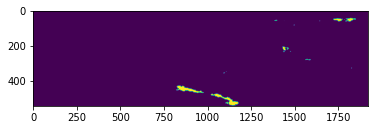

In [8]:
plt.imshow(output)

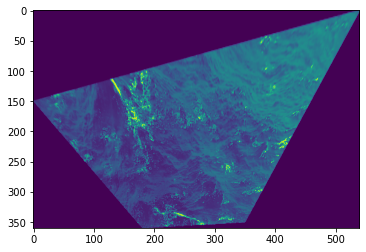

In [9]:
plt.imshow(img_roi_rec)

True

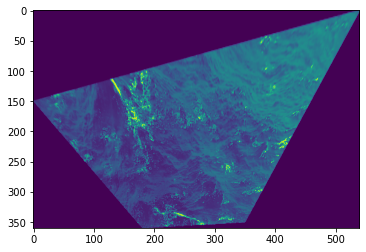

In [10]:
plt.imshow(aaa)
cv2.imwrite('example2.png', aaa)

True

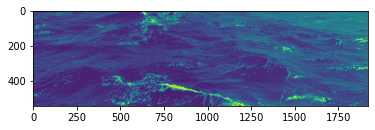

In [11]:
plt.imshow(img_roi)
cv2.imwrite('example1.png', img_roi)

True

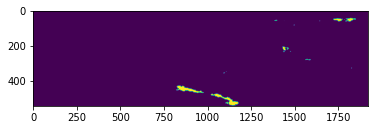

In [12]:
plt.imshow(output)
cv2.imwrite('example1_a.png', output*255)

True

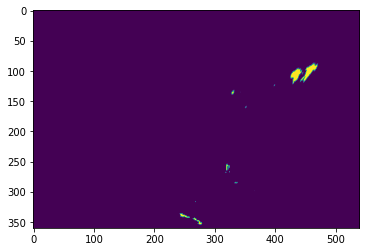

In [13]:
plt.imshow(output_rectified)
cv2.imwrite('example22.png', output_rectified*255)

In [16]:
active_whitecaps_area

874

In [15]:
area

100446

In [20]:
img_roi_rec.size

194400

In [21]:
874/194400

0.004495884773662551

In [14]:
active_whitecaps_fraction

0.008701192680644326

## Loop Test

In [7]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

result = pd.DataFrame(columns=('date','camera','video','image_fname',
                               'active_whitecaps','active_whitecaps_fraction',
                               'predict_image'))

In [8]:
import os

store_path = "E:\GoPro_1Hz"
date_folder = []

# get the names of the folders that store images
for file in os.listdir(store_path):
    if os.path.isdir(os.path.join(store_path, file)):
        date_folder.append(file)

# get the name of the folders that store one of these cameras
camera_folder = os.listdir(os.path.join(store_path, date_folder[0]))

# get the name of the folders that store images of these videos
video_path = os.path.join(store_path, date_folder[0], camera_folder[0])
video_folder = os.listdir(video_path)
# get the name of each image
image_path = os.path.join(video_path, video_folder[0])
image_file = os.listdir(image_path)
image_file.sort(key=lambda x:int(x[14:-4]))

In [9]:
date_folder

['2020_3_4_GoPro', '2020_3_5_GoPro', '2020_3_6_GoPro', '2020_3_7_GoPro']

In [10]:
camera_folder

['image_left', 'image_right']

In [11]:
video_folder

['GH010004.MP4',
 'GH010005.MP4',
 'GH010006.MP4',
 'GH020004.MP4',
 'GH020005.MP4',
 'GH020006.MP4',
 'GH030004.MP4',
 'GH030005.MP4',
 'GH030006.MP4',
 'GH040004.MP4',
 'GH040005.MP4',
 'GH040006.MP4',
 'GH050004.MP4',
 'GH050005.MP4',
 'GH050006.MP4',
 'GH060004.MP4',
 'GH060005.MP4',
 'GH060006.MP4',
 'GH070004.MP4',
 'GH070005.MP4',
 'GH070006.MP4',
 'GH080004.MP4',
 'GH080005.MP4',
 'GH080006.MP4',
 'GH090004.MP4',
 'GH090005.MP4',
 'GH090006.MP4']

In [12]:
image_file

['original_frame1.jpg',
 'original_frame2.jpg',
 'original_frame3.jpg',
 'original_frame4.jpg',
 'original_frame5.jpg',
 'original_frame6.jpg',
 'original_frame7.jpg',
 'original_frame8.jpg',
 'original_frame9.jpg',
 'original_frame10.jpg',
 'original_frame11.jpg',
 'original_frame12.jpg',
 'original_frame13.jpg',
 'original_frame14.jpg',
 'original_frame15.jpg',
 'original_frame16.jpg',
 'original_frame17.jpg',
 'original_frame18.jpg',
 'original_frame19.jpg',
 'original_frame20.jpg',
 'original_frame21.jpg',
 'original_frame22.jpg',
 'original_frame23.jpg',
 'original_frame24.jpg',
 'original_frame25.jpg',
 'original_frame26.jpg',
 'original_frame27.jpg',
 'original_frame28.jpg',
 'original_frame29.jpg',
 'original_frame30.jpg',
 'original_frame31.jpg',
 'original_frame32.jpg',
 'original_frame33.jpg',
 'original_frame34.jpg',
 'original_frame35.jpg',
 'original_frame36.jpg',
 'original_frame37.jpg',
 'original_frame38.jpg',
 'original_frame39.jpg',
 'original_frame40.jpg',
 'origina

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for fname in image_file:
    
    path = os.path.join(image_path, fname)
    img = cv2.imread(path)
    roi_up, roi_bottom, line, rho, theta = get_ROI(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    img_roi = img[roi_up: roi_bottom+1, 0:1920]
    img_roi_tensor = torch.from_numpy(img_roi / 255).float()
    img_roi_tensor = img_roi_tensor.unsqueeze(0)
    img_roi_tensor = img_roi_tensor.unsqueeze(0)
    unet_model.to(device)
    img_roi_tensor = img_roi_tensor.to(device)
    
    with torch.no_grad():
        output = unet_model(img_roi_tensor)
    output = output.squeeze(0)
    output = output.squeeze(0)
    
    # assign all large than 0.8 as 1 and less as 0
    output = output.cpu().numpy()

    output[output >= 0.8] = 1
    output[output < 0.8] = 0

    output_BGR = cv2.cvtColor(output, cv2.COLOR_GRAY2BGR)
    output_rectified = rectify(img,IntrinsicMatrix,H,incStab,rollStab,
                            aziStab,line,rho,theta,output)

    img_roi_rec = rectify(img,IntrinsicMatrix,H,incStab,rollStab,
                        aziStab,line,rho,theta,img_roi)
    area = img_roi_rec[img_roi_rec>0].size
    active_whitecaps = np.argwhere(output_rectified>0)
    active_whitecaps_area = output_rectified[output_rectified>0].size
    active_whitecaps_fraction = active_whitecaps_area / area
    result = result.append(pd.DataFrame({
        'date':[date_folder[0]],
        'camera':[camera_folder[0]],
        'video':[video_folder[0]],
        'image_fname':[fname],
        'active_whitecaps':[active_whitecaps],
        'active_whitecaps_fraction':[active_whitecaps_fraction],
        'predict_image':[output]
    }))

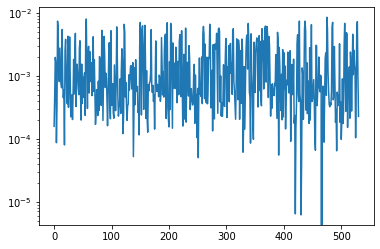

In [19]:
result = result.reset_index(drop=True)
result.to_csv("E:/GoPro_1Hz_Unet_output/test_2022_6_26.csv")
plt.semilogy(np.arange(531), result['active_whitecaps_fraction'].values.astype(float))

# Loop For one Day

In [ ]:
import os

store_path = "E:\GoPro_1Hz"
date_folder = []

# get the names of the folders that store images
for file in os.listdir(store_path):
    if os.path.isdir(os.path.join(store_path, file)):
        date_folder.append(file)

# get the name of the folders that store one of these cameras
camera_folder = os.listdir(os.path.join(store_path, date_folder[0]))

# get the name of the folders that store images of these videos
video_path = os.path.join(store_path, date_folder[0], camera_folder[0])
video_folder = os.listdir(video_path)
# get the name of each image
image_path = os.path.join(video_path, video_folder[0])
image_file = os.listdir(image_path)
image_file.sort(key=lambda x:int(x[14:-4]))

In [ ]:
store_path = "E:\GoPro_1Hz"
date_folder = []

# get the names of the folders that store images
for file in os.listdir(store_path):
    if os.path.isdir(os.path.join(store_path, file)):
        date_folder.append(file)

for i in range(1,3):
    # get the name of the folders that store one of these cameras
    camera_folder = os.listdir(os.path.join(store_path, date_folder[i+1]))

    for camera_i in camera_folder:
        video_path = os.path.join(store_path, date_folder[i+1], camera_i)
        video_folder = os.listdir(video_path)
        for video_id in video_folder:
            image_path = os.path.join(video_path, video_id)
            image_file = os.listdir(image_path)
            result = pd.DataFrame(columns=('date','camera','video','image_fname',
                                'active_whitecaps','active_whitecaps_fraction',
                                'predict_image'))

            for fname in image_file[:]:
                if fname[0:2] =='._':
                    os.remove(os.path.join(image_path, fname))
                    image_file.remove(fname)
                    
            image_file.sort(key=lambda x:int(x[14:-4]))
            

            print(f'The code is working on {date_folder[i+1]}-{camera_i}-{video_id}!!!')
            for fname in image_file:

                path = os.path.join(image_path, fname)
                img = cv2.imread(path)
                
                try:
                    roi_up, roi_bottom, horizon, line, rho, theta = get_ROI(img)
                except:
                    result = result.append(pd.DataFrame({
                    'date':[date_folder[i+1]],
                    'camera':[camera_i],
                    'video':[video_id],
                    'image_fname':[fname],
                    'active_whitecaps':[0],
                    'active_whitecaps_fraction':[0],
                    'predict_image':[0]
                    }))
                else:
                    
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    
                    img_roi = img[roi_up: roi_bottom+1, 0:1920]
                    img_roi_tensor = torch.from_numpy(img_roi / 255).float()
                    img_roi_tensor = img_roi_tensor.unsqueeze(0)
                    img_roi_tensor = img_roi_tensor.unsqueeze(0)
                    unet_model.to(device)
                    img_roi_tensor = img_roi_tensor.to(device)
                    
                    with torch.no_grad():
                        output = unet_model(img_roi_tensor)
                    output = output.squeeze(0)
                    output = output.squeeze(0)
                    
                    # assign all large than 0.8 as 1 and less as 0
                    output = output.cpu().numpy()
                    output[output >= 0.8] = 1
                    output[output < 0.8] = 0

                    output_BGR = cv2.cvtColor(output, cv2.COLOR_GRAY2BGR)
                    output_rectified = rectify(img,IntrinsicMatrix,H,incStab,rollStab,
                                            aziStab,line,rho,theta,output)

                    img_roi_rec = rectify(img,IntrinsicMatrix,H,incStab,rollStab,
                                        aziStab,line,rho,theta,img_roi)
                    area = img_roi_rec[img_roi_rec>0].size
                    active_whitecaps = np.argwhere(output_rectified>0)
                    active_whitecaps_area = output_rectified[output_rectified>0].size
                    active_whitecaps_fraction = active_whitecaps_area / area
                    result = result.append(pd.DataFrame({
                        'date':[date_folder[i+1]],
                        'camera':[camera_i],
                        'video':[video_id],
                        'image_fname':[fname],
                        'active_whitecaps':[active_whitecaps],
                        'active_whitecaps_fraction':[active_whitecaps_fraction],
                        'predict_image':[output]
                    }))
            result = result.reset_index(drop=True)
            if not os.path.exists(f"E:/GoPro_1Hz_Unet_output/{date_folder[i+1]}/{camera_i}"):
                os.makedirs(f"E:/GoPro_1Hz_Unet_output/{date_folder[i+1]}/{camera_i}")
            result.to_csv(f"E:/GoPro_1Hz_Unet_output/{date_folder[i+1]}/{camera_i}/{video_id[0:-4]}_active.csv")
            

# Processing Loop

In [14]:
import os

store_path = "E:\GoPro_1Hz"
date_folder = [] = []

# get the names of the folders that store images
for file in os.listdir(store_path):
    if os.path.isdir(os.path.join(store_path, file)):
        date_folder.append(file)

for i in range(4):
    # get the name of the folders that store one of these cameras
    camera_folder = os.listdir(os.path.join(store_path, date_folder[i]))

In [23]:
date_folder 

['2020_3_4_GoPro', '2020_3_5_GoPro', '2020_3_6_GoPro', '2020_3_7_GoPro']

In [27]:
for i in range(1):
    i = i + 2
    print(i)

2


In [17]:
camera_folder

['image_behind', 'image_left', 'image_right']

In [28]:
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
store_path = "E:\GoPro_1Hz"
date_folder = []

# get the names of the folders that store images
for file in os.listdir(store_path):
    if os.path.isdir(os.path.join(store_path, file)):
        date_folder.append(file)

for i in range(1):
    i = i + 2
    # get the name of the folders that store one of these cameras
    camera_folder = os.listdir(os.path.join(store_path, date_folder[i]))
    

    for camera_i in camera_folder:
        video_path = os.path.join(store_path, date_folder[i], camera_i)
        video_folder = os.listdir(video_path)
        for video_id in video_folder:
            image_path = os.path.join(video_path, video_id)
            image_file = os.listdir(image_path)
            result = pd.DataFrame(columns=('date','camera','video','image_fname',
                                'active_whitecaps','active_whitecaps_fraction',
                                'predict_image'))

            for fname in image_file[:]:
                if fname[0:2] =='._':
                    os.remove(os.path.join(image_path, fname))
                    image_file.remove(fname)
                    
            image_file.sort(key=lambda x:int(x[14:-4]))
            

            print(f'The code is working on {date_folder[i]}-{camera_i}-{video_id}!!!')
            for fname in image_file:

                path = os.path.join(image_path, fname)
                img = cv2.imread(path)
                
                try:
                    roi_up, roi_bottom, line, rho, theta = get_ROI(img)
                except:
                    result = result.append(pd.DataFrame({
                    'date':[date_folder[i]],
                    'camera':[camera_i],
                    'video':[video_id],
                    'image_fname':[fname],
                    'active_whitecaps':[0],
                    'active_whitecaps_fraction':[0],
                    'predict_image':[0]
                    }))
                else:
                    
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    
                    img_roi = img[roi_up: roi_bottom+1, 0:1920]
                    img_roi_tensor = torch.from_numpy(img_roi / 255).float()
                    img_roi_tensor = img_roi_tensor.unsqueeze(0)
                    img_roi_tensor = img_roi_tensor.unsqueeze(0)
                    unet_model.to(device)
                    img_roi_tensor = img_roi_tensor.to(device)
                    
                    with torch.no_grad():
                        output = unet_model(img_roi_tensor)
                    output = output.squeeze(0)
                    output = output.squeeze(0)
                    
                    # assign all large than 0.8 as 1 and less as 0
                    output = output.cpu().numpy()
                    output[output >= 0.8] = 1
                    output[output < 0.8] = 0

                    output_BGR = cv2.cvtColor(output, cv2.COLOR_GRAY2BGR)
                    output_rectified = rectify(img,IntrinsicMatrix,H,incStab,rollStab,
                                            aziStab,line,rho,theta,output)

                    img_roi_rec = rectify(img,IntrinsicMatrix,H,incStab,rollStab,
                                        aziStab,line,rho,theta,img_roi)
                    area = img_roi_rec[img_roi_rec>0].size
                    active_whitecaps = np.argwhere(output_rectified>0)
                    active_whitecaps_area = output_rectified[output_rectified>0].size
                    active_whitecaps_fraction = active_whitecaps_area / area
                    result = result.append(pd.DataFrame({
                        'date':[date_folder[i]],
                        'camera':[camera_i],
                        'video':[video_id],
                        'image_fname':[fname],
                        'active_whitecaps':[active_whitecaps],
                        'active_whitecaps_fraction':[active_whitecaps_fraction],
                        'predict_image':[output]
                    }))
            result = result.reset_index(drop=True)
            if not os.path.exists(f"E:/GoPro_1Hz_Unet_output/{date_folder[i]}/{camera_i}"):
                os.makedirs(f"E:/GoPro_1Hz_Unet_output/{date_folder[i]}/{camera_i}")
            result.to_csv(f"E:/GoPro_1Hz_Unet_output/{date_folder[i]}/{camera_i}/{video_id[0:-4]}_active.csv")
                

The code is working on 2020_3_6_GoPro-image_behind-GH010005.MP4!!!
The code is working on 2020_3_6_GoPro-image_behind-GH010006.MP4!!!
The code is working on 2020_3_6_GoPro-image_behind-GH010007.MP4!!!
The code is working on 2020_3_6_GoPro-image_behind-GH010008.MP4!!!
The code is working on 2020_3_6_GoPro-image_behind-GH010009.MP4!!!
The code is working on 2020_3_6_GoPro-image_behind-GH010010.MP4!!!
The code is working on 2020_3_6_GoPro-image_behind-GH020005.MP4!!!
The code is working on 2020_3_6_GoPro-image_behind-GH020006.MP4!!!
The code is working on 2020_3_6_GoPro-image_behind-GH020007.MP4!!!
The code is working on 2020_3_6_GoPro-image_behind-GH020008.MP4!!!
The code is working on 2020_3_6_GoPro-image_behind-GH020009.MP4!!!
The code is working on 2020_3_6_GoPro-image_behind-GH020010.MP4!!!
The code is working on 2020_3_6_GoPro-image_behind-GH030005.MP4!!!
The code is working on 2020_3_6_GoPro-image_behind-GH030006.MP4!!!
The code is working on 2020_3_6_GoPro-image_behind-GH030007.MP

In [ ]:
# 2020_3_6需要重新运行一下。

In [20]:
img_roi_tensor

tensor([], device='cuda:0', size=(1, 1, 0, 1920))

In [21]:
video_id

'GH090010.MP4'

In [22]:
fname

'original_frame71.jpg'